In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import image_dataset_from_directory
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [4]:
# applying different data augumentation methods to the training data
train_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

valid_gen = ImageDataGenerator(
    rescale = 1/255,
    validation_split=0.2
)

In [5]:
Image_size = (255, 255)
Batch_size = 32

In [6]:
#Loading the training and validation data from the director
data_dir = "../input/plantvillage-dataset/segmented"
train_generator = train_gen.flow_from_directory(
    data_dir,
    target_size = Image_size,
    batch_size = Batch_size,
    subset= "training",
    class_mode = "categorical",
    color_mode = "rgb"
    
)

valid_generator = valid_gen.flow_from_directory(
    data_dir,
    target_size = Image_size,
    batch_size = Batch_size,
    subset= "validation",
    class_mode = "categorical",
    color_mode = "rgb"
    
    
)

Found 43457 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [7]:
model = VGG16(include_top=False, input_shape=(255,255,3), weights="imagenet")
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)
dense1 = Dense(1024, activation="relu")(x)
prediction = Dense(38, activation="softmax")(dense1)
model = Model(inputs=model.inputs, outputs=prediction)

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

In [9]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.n // train_generator.batch_size,    #The 2 slashes division return rounded integer
        epochs = 5,
        validation_data = valid_generator,
        validation_steps = valid_generator.n // valid_generator.batch_size
        )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1358/1358 [==============================] - 1096s 799ms/step - loss: 0.7306 - accuracy: 0.8019 - precision: 0.8810 - recall: 0.7477 - auc: 0.9865 - val_loss: 0.3402 - val_accuracy: 0.8878 - val_precision: 0.9163 - val_recall: 0.8689 - val_auc: 0.9955
Epoch 2/5
1358/1358 [==============================] - 766s 564ms/step - loss: 0.3763 - accuracy: 0.8752 - precision: 0.9063 - recall: 0.8522 - auc: 0.9951 - val_loss: 0.3424 - val_accuracy: 0.8887 - val_precision: 0.9111 - val_recall: 0.8715 - val_auc: 0.9951
Epoch 3/5
1358/1358 [==============================] - 759s 559ms/step - loss: 0.3253 - accuracy: 0.8945 - precision: 0.9190 - recall: 0.8781 - auc: 0.9955 - val_loss: 0.2511 - val_accuracy: 0.9180 - val_precision: 0.9362 - val_recall: 0.9062 - val_auc: 0.9969
Epoch 4/5
1358/1358 [==============================] - 759s 559ms/step - loss: 0.3006 - accuracy: 0.9015 - precision: 0.9218 - recall: 0.8884 - auc: 0.9957 - val_loss: 0.2494 - val_accuracy: 0.9232 - val_precision: 0

In [10]:
model.save('vgg_segmented_model.h5')

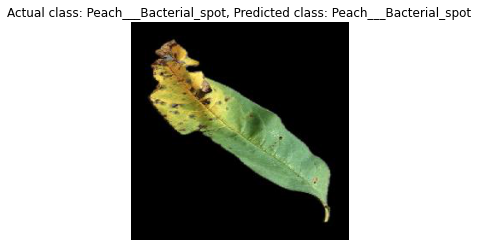

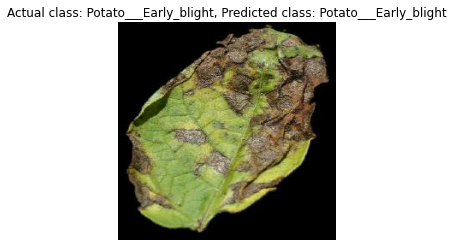

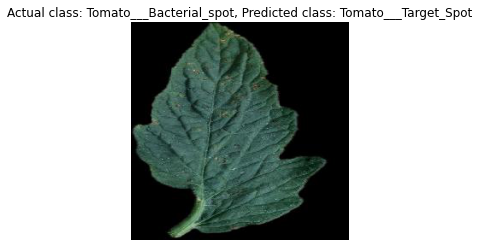

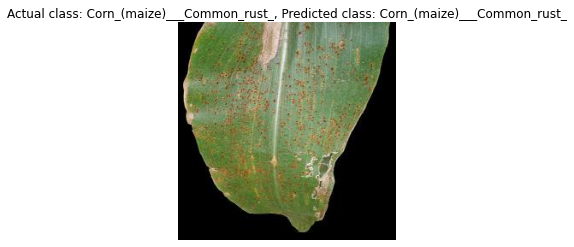

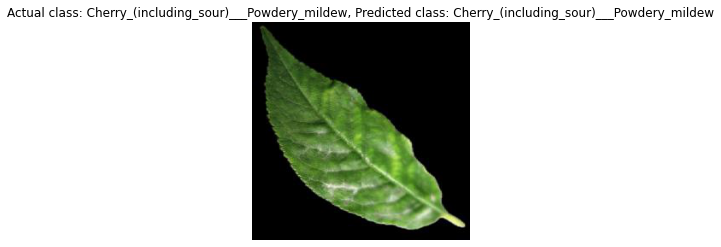

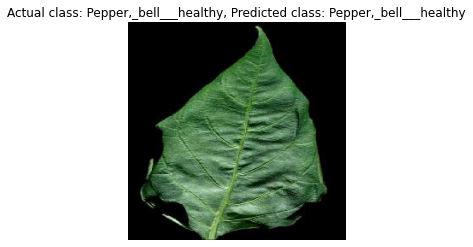

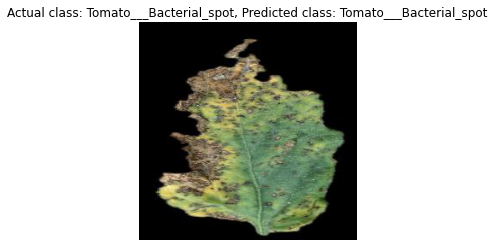

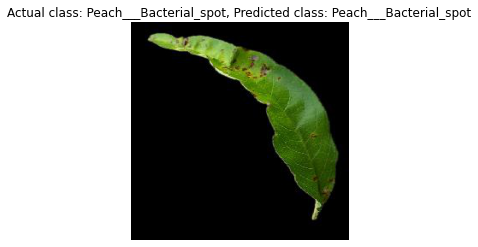

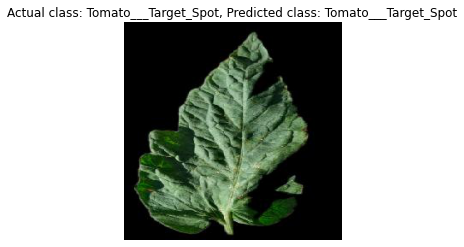

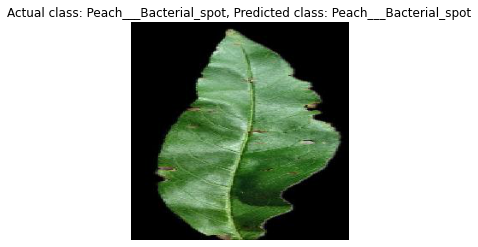

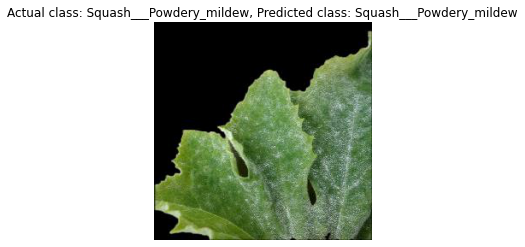

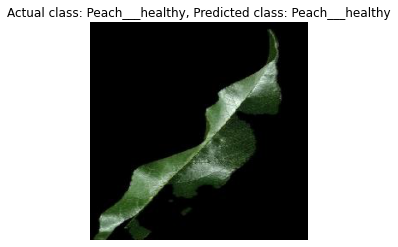

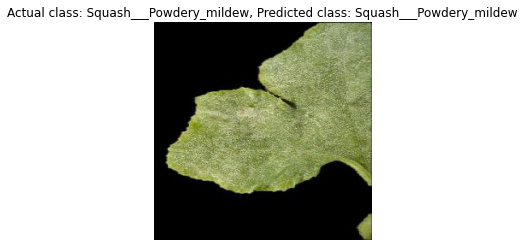

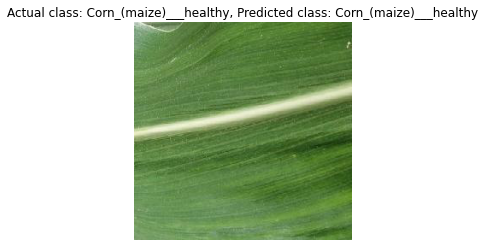

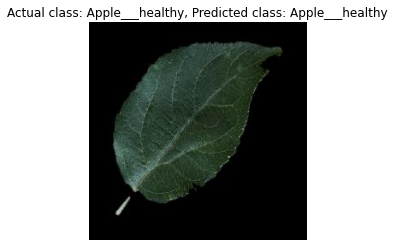

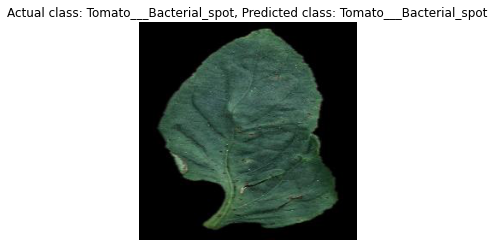

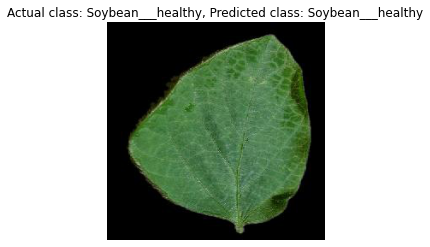

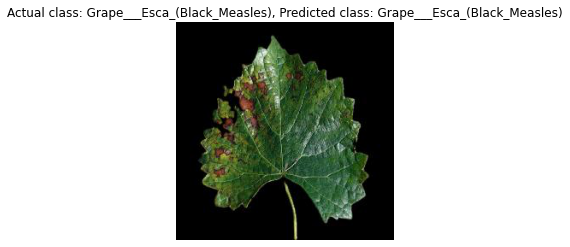

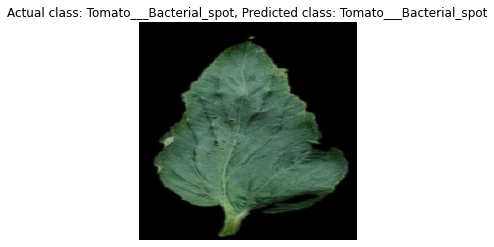

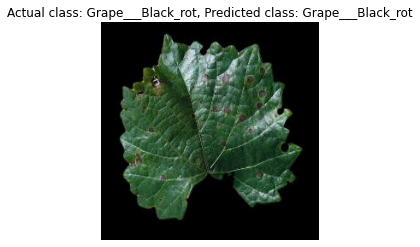

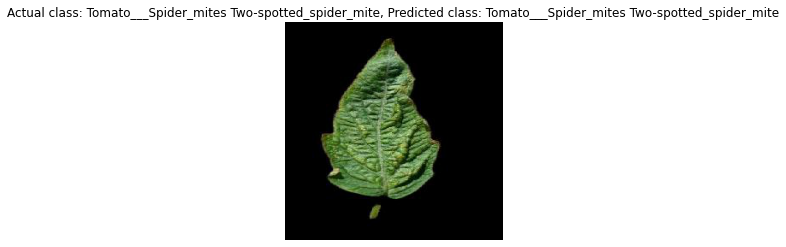

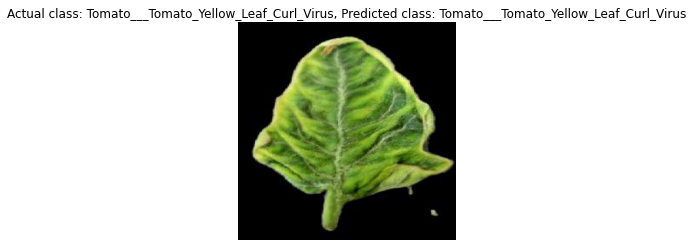

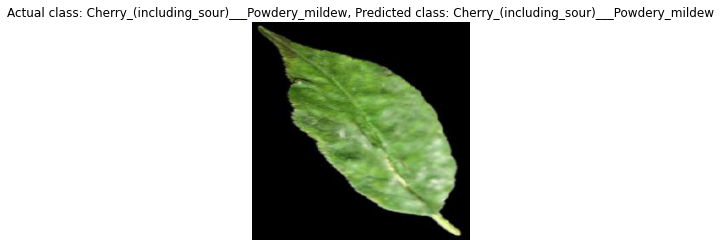

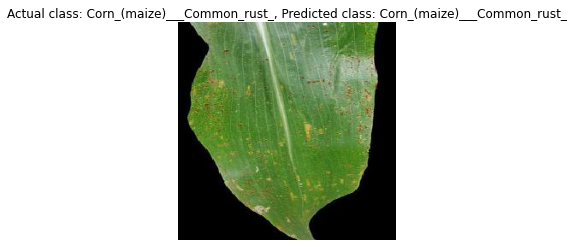

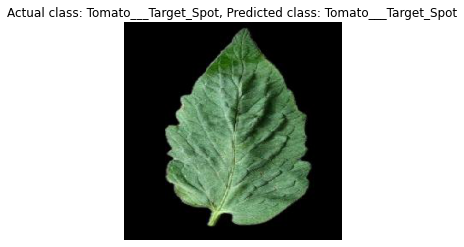

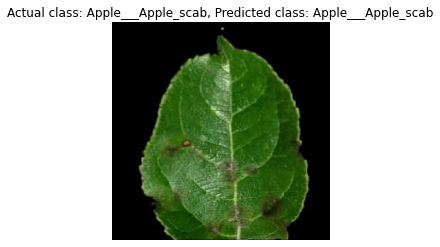

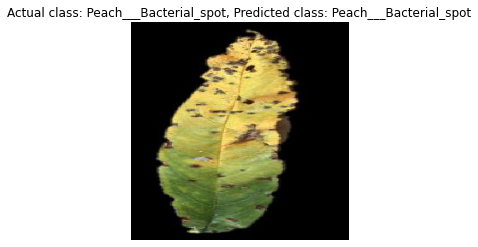

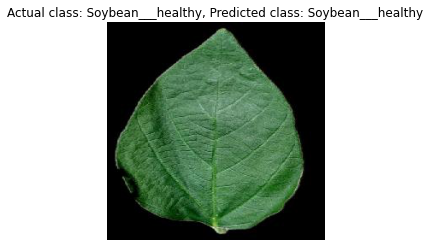

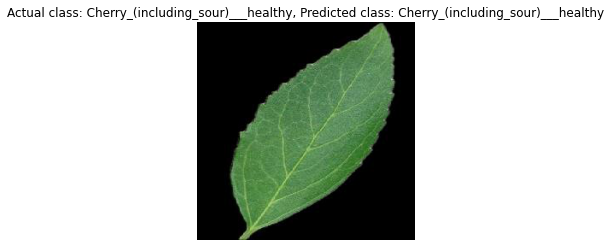

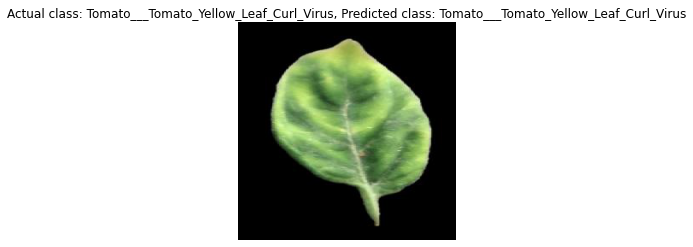

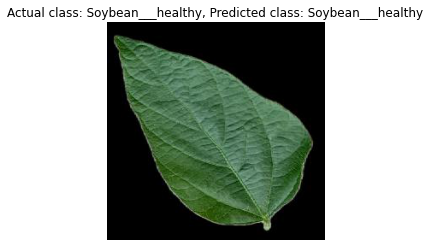

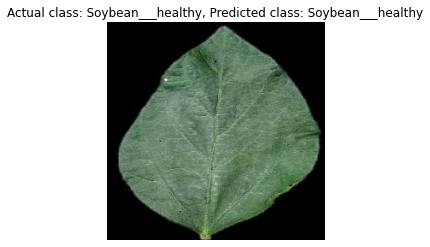

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight',
    'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
    'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

# Reset the validation generator to start from the beginning
valid_generator.reset()

# Predict classes for one batch from the validation set
batch_images, batch_labels = valid_generator.next()  # Get one batch of images and labels

predictions = model.predict(batch_images)  # Make predictions for the batch

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Display the images along with their actual and predicted classes
for i in range(len(batch_labels)):
    # Load and display the image
    img = batch_images[i]
    plt.imshow(img)
    plt.axis('off')

    # Display the actual and predicted classes
    actual_class = class_names[np.argmax(batch_labels[i])]
    predicted_class = class_names[predicted_classes[i]]
    plt.title(f"Actual class: {actual_class}, Predicted class: {predicted_class}")
    plt.show()

In [12]:
evaluation = model.evaluate_generator(valid_generator)

# Extract accuracy from the evaluation result
accuracy = evaluation[1]  # Assuming accuracy is the second element in the evaluation result

print("Validation Accuracy:", accuracy)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation Accuracy: 0.9153839349746704


In [13]:
from sklearn.metrics import classification_report

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
# y_true and y_pred should be arrays or lists containing the true and predicted labels respectively

# Calculate accuracy
accuracy = model.evaluate_generator(valid_generator)[1]  # Extract accuracy from the evaluation result

# Calculate predicted labels
y_pred = model.predict_generator(valid_generator).argmax(axis=1)

# Calculate true labels
y_true = valid_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)

print("Validation Accuracy:", accuracy)
print("Classification Report:")
print(report)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Validation Accuracy: 0.9153839349746704
Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.02      0.02      0.02       126
                                 Apple___Black_rot       0.02      0.02      0.02       124
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.04      0.04      0.04       329
                               Blueberry___healthy       0.04      0.04      0.04       300
          Cherry_(including_sour)___Powdery_mildew       0.03      0.03      0.03       210
                 Cherry_(including_sour)___healthy       0.01      0.01      0.01       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       102
                       Corn_(maize)___Common_rust_       0.04      0.04      0.04       238
               C

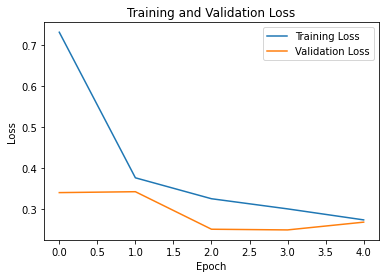

In [14]:
import matplotlib.pyplot as plt

# Training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

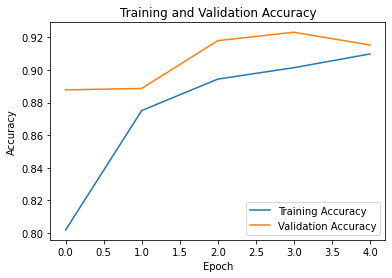

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
